In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from dataclasses import dataclass, field
from typing import List
from matplotlib.lines import Line2D
import math

In [44]:
# Read data rating data
names = ['userid', 'itemid', 'rating', 'timestamp']
raw_data = pd.read_csv('./ml-100k/u.data', sep='\t', names=names)

# save data in a numpy array where each user ratings have their own rows
userids = sorted(list(raw_data['userid'].unique()))
itemids = sorted(list(raw_data['itemid'].unique()))

# first save in list of lists, use None values if user has not rated item
data = [[None] * len(itemids) for x in range(len(userids))]

# find ratings made by each user
for i in range(len(userids)):
    # dict of ratings for user i+1 (key = itemid, value = rating)
    user_ratings = dict(zip(raw_data.loc[raw_data['userid'] == (i+1)].itemid, raw_data.loc[raw_data['userid'] == (i+1)].rating))
    for j in range(len(itemids)):
        # check if user has rated item with id j+1
        if j+1 in user_ratings:
            data[i][j] = user_ratings[j+1]

data = np.array(data)

# Read movie name and genre data
genres = pd.read_csv('./ml-100k/u.genre', sep='|', names=['genre', 'id'])
genres = genres['genre'].tolist()
names = ['itemid', 'name', 'date', 'moviedate', 'url'] + genres
item_data = pd.read_csv('./ml-100k/u.item', sep='|', names=names, encoding = "ISO-8859-1", header=None)

In [79]:
# Movie data class, saves movie name and genres it belongs to 

@dataclass
class Movie:
    id: int
    title: str
    genres: List[str] = field(default_factory=list)

movies = []

for id in itemids:
    item = item_data.loc[item_data['itemid'] == id].values.tolist()[0]
    
    tmp_genres = []
    i = 0
    for g in item[5:]:
        belongs = g
        if belongs:
            tmp_genres.append(genres[i])
        i += 1

    movies.append(Movie(id, item[1], tmp_genres))

## User-based collaborative filtering approach from Assignment 1

In [4]:
# a, b = userids, data = whole data set
def similarity(a,b, data):
    data_a = data[a-1] # remember that indexing starts from 0, but userids from 1
    data_b = data[b-1]

    # dicts with itemids and ratings
    dict_a = {i: r for i, r in enumerate(data_a, start=1) if r is not None}
    dict_b = {i: r for i, r in enumerate(data_b, start=1) if r is not None}

    # intersections of common itemids
    P = list(set(dict_a).intersection(set(dict_b)))

    if len(P) < 2:
        return 0

    # keep only common itemids
    dict_a = {id: dict_a[id] for id in P}
    dict_b = {id: dict_b[id] for id in P}

    # Create constants
    const_a = list(dict_a.values())
    const_b = list(dict_b.values())

    sim, p = stats.pearsonr(const_a, const_b)

    # Check for NaN
    if sim != sim:
        return 0
    return sim

In [5]:
# Similarity matrix
N = 0
sim_matrix = [[1] * len(userids) for x in range(len(userids))]
for i in range(len(userids)):
    for j in range(i+1, len(userids)):
        sim_matrix[i][j] = sim_matrix[j][i] = similarity(i+1, j+1, data)

sim_matrix = np.array(sim_matrix)

B:\Anaconda\envs\recommender\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [6]:
# a = userid, p = itemid, data = whole data set, 
# sim = similarity matrix t = similarity threshold
def predict(a, p, data, sim_matrix, t):
    sim = sim_matrix[a-1]
    # mean of ratings given by user a
    mean_a = np.mean([r for r in data[a-1] if r is not None])

    # transform similarities to dict (key = userid, value = similarity) and filter out unvanted similarities
    sim = {i: s for i, s in enumerate(sim, start=1) if s >= t}

    n = 0
    d = 0

    for b in sim:
        # chekc if user b has not rated the item
        if data[b-1][p-1] == None:
            continue

        mean_b = np.mean([r for r in data[b-1] if r is not None])
        n += sim[b] * (data[b-1][p-1] - mean_b)
        d += sim[b]

    if n == 0:
        return mean_a

    return mean_a + n/d

## Average aggregation method

In [7]:
# g = groud of users (list of usedids), i = itemid, data = whole dataset
def average_aggregation(g, i, data):
    # ratings for item i, given by users in the group
    ratings = []

    # obtaing ratings, either from data or predict it
    for user in g:
        rating = data[user-1][i-1]
        if rating == None:
            rating = predict(user, i, data, sim_matrix, 10)
        ratings.append(rating)
    
    return np.average(ratings)

## Top 20 recommendations for a group of 3 users

In [87]:
g = [1, 11, 111]
# dict for group ratings for all items (key=itemid, value=group rating for item)
ratings = {}

for i in itemids:
    ratings[i] = average_aggregation(g, i, data)

# sort dict so that highly rated items for the group are first
ratings = dict(sorted(ratings.items(), key=lambda x: x[1], reverse=True))

recommendations = dict(list(ratings.items())[:20])
df = pd.DataFrame(list(zip(list(recommendations.keys()), list(recommendations.values()))), columns=['itemid', 'rating'])
print(df)

    itemid    rating
0      258  4.666667
1        9  4.513889
2       15  4.513889
3      173  4.513889
4      196  4.513889
5      268  4.513889
6      269  4.488029
7      286  4.203431
8       28  4.180556
9       86  4.180556
10     100  4.180556
11     111  4.180556
12     191  4.180556
13     208  4.180556
14     242  4.154696
15     277  4.050654
16     318  4.050654
17     332  4.050654
18     357  4.050654
19     423  4.050654
20     429  4.050654


In [93]:
# itemid = why not this item, r = ratings for all items for the group, g = group userids, data = whole dataset
def granularity_case_atomic(itemid, r, g, data):
    # check if item does not exist in data
    if itemid not in itemids:
        print('does not exist :\'(')
        return

    # groups rating for the item in question
    rating = r[itemid]

    # ratings in list format (needed to get indeces)
    ratings_list = list(ratings.items())

    # placing on the group ratings (best = 1)
    index = list(ratings.keys()).index(itemid) + 1

    # check if item was actually recommended
    if index <= 20:
        print('item WAS recommended, dummy')
        return

    # check tie break
    if rating == ratings_list[19][1]:
        print('tie break')

    # check if item would have been recommended if user asked for more items
    # threshold for this case = 20
    if index <= 40:
        print('user asked for too few items')


granularity_case_atomic(5321321, ratings, g, data)
granularity_case_atomic(9, ratings, g, data)
granularity_case_atomic(429, ratings, g, data)

does not exist :'(
4.513888888888888
2
item WAS recommended, dummy
4.050653594771242
21
tie break
user asked for too few items


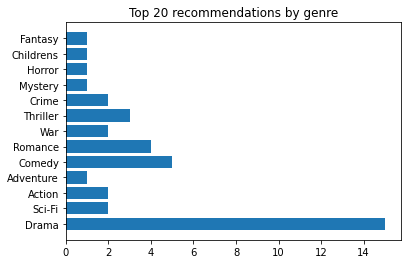

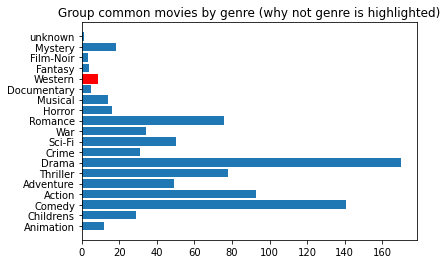

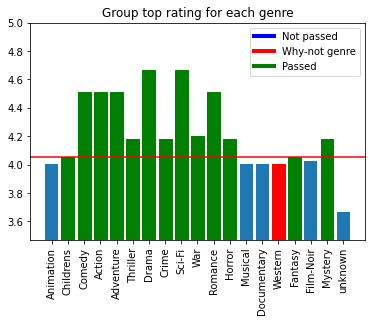

Probability that genre Western appears in the groups top 20 (assuming that the group on average likes all genres equally):
33.905 %


In [180]:
def granularity_case_group(why_not_genre, r, g, data):
    # ratings in list format (needed to get indeces)
    ratings_list = list(ratings.items())
    
    recommendations_histogram, genre_rating_avg_all, genre_rating_avg, genre_rating_max, genre_histogram, seen_movies= group_genre_data(g, r, data)

    # top 20 recommendation genre histogram
    plt.barh(list(recommendations_histogram.keys()), recommendations_histogram.values())
    plt.title('Top 20 recommendations by genre')
    plt.show()

    # Groups common movies genre histogram
    genre_index = list(genre_histogram.keys()).index(why_not_genre)
    barlist = plt.barh(list(genre_histogram.keys()), genre_histogram.values())
    barlist[genre_index].set_color('r')
    plt.title('Group common movies by genre (why not genre is highlighted)')
    plt.show()

    # Group top rating for each genre
    genre_index = list(genre_rating_max.keys()).index(why_not_genre)
    genre_max = plt.bar(list(genre_rating_max.keys()), genre_rating_max.values())
    genre_max[genre_index].set_color('r')

    for genre in recommendations_histogram:
        index = list(genre_rating_max.keys()).index(genre)
        genre_max[index].set_color('g')
    
    plt.axhline(y=ratings_list[19][1], color='r', linestyle='-')
    ax = plt.gca()
    ax.set_ylim([min(list(genre_rating_max.values()))-0.2, 5])
    custom_lines = [Line2D([0], [0], color='b', lw=4),
                    Line2D([0], [0], color='r', lw=4),
                    Line2D([0], [0], color='g', lw=4)]

    ax.legend(custom_lines, ['Not passed', 'Why-not genre', 'Passed'])
    plt.xticks(rotation=90)
    plt.title('Group top rating for each genre')
    plt.show()

    # probability that the why-not genre appears in top 20
    why_not_genre_movies = genre_histogram[why_not_genre]
    prob = 1 - (math.comb(seen_movies - why_not_genre_movies, 20) / math.comb(seen_movies, 20))


    print('Probability that genre', why_not_genre, 'appears in the groups top 20 (assuming that the group on average likes all genres equally):')
    print(np.round(prob * 100, 3),  '%')

granularity_case_group('Western', ratings, g, data)

In [162]:
# get genre data for the groups recommended movies and seen movies
def group_genre_data(g, r, data):
    # top 20 recommendations histogram
    recommendations_histogram = {}

    # ratings in list format (needed to get indeces)
    ratings_list = list(ratings.items())

    for movie in ratings_list[:20]:
        for genre in movies[movie[0]-1].genres:
            if genre not in recommendations_histogram:
                recommendations_histogram[genre] = 1
            else:
                recommendations_histogram[genre] = recommendations_histogram[genre] + 1

    # group average ratings for all movies
    genre_rating_avg_all = {}
    for movie in ratings_list:
        for genre in movies[movie[0]-1].genres:
            if genre not in genre_rating_avg_all:
                genre_rating_avg_all[genre] = [movie[1]]
            else:
                tmp_genre_ratings = genre_rating_avg_all[genre]
                tmp_genre_ratings.append(movie[1])
                genre_rating_avg_all[genre] = tmp_genre_ratings
    
    for genre in genre_rating_avg_all:
        genre_rating_avg_all[genre] = np.average(genre_rating_avg_all[genre])

    
    # see what genres the users in the group have watched and ratings for movies in those genres
    genre_ratings = {}
    genre_histogram = {}
    seen_movies = []
    for user in g:
        for itemid in itemids:
            rating = data[user-1][itemid-1]
            if rating != None:
                if itemid not in seen_movies:
                    for genre in movies[itemid-1].genres:
                        if genre not in genre_histogram:
                            genre_histogram[genre] = 1
                        else:
                            genre_histogram[genre] = genre_histogram[genre] + 1

                        if genre not in genre_ratings:
                            genre_ratings[genre] = [r[itemid]]
                        else:
                            tmp_genre_ratings = genre_ratings[genre]
                            tmp_genre_ratings.append(r[itemid])
                            genre_ratings[genre] = tmp_genre_ratings
                    
                    # keep track the movies that have already been taken into account in histogram and average
                    seen_movies.append(itemid)
    
    genre_rating_avg = {}
    genre_rating_max = {}

    for genre in genre_ratings:
        genre_rating_avg[genre] = np.average(genre_ratings[genre])
        genre_rating_max[genre] = max(genre_ratings[genre])
    
    return recommendations_histogram, genre_rating_avg_all, genre_rating_avg, genre_rating_max, genre_histogram, len(seen_movies)

In [9]:
def disagreement_variance(g, i, data):
    # ratings for item i, given by users in the group
    ratings = []

    # obtaing ratings, either from data or predict it
    for user in g:
        rating = data[user-1][i-1]
        if rating == None:
            rating = predict(user, i, data, sim_matrix, 10)
        ratings.append(rating)
    
    ratings_mean = np.mean(ratings)

    # calculate and return the disagreement variance acording to the formula presented above
    dis = (1/len(ratings) * np.sum([(r - ratings_mean) ** 2 for r  in ratings]))
    return dis

In [10]:
def consensus(g, i, data):
    w1 = 0.9
    w2 = 1-w1
    return w1 * average_aggregation(g, i, data) + w2 * (1-disagreement_variance(g, i, data))